# Text Classification
Using a 2022[ World Cup data set from Kaggle.com](https://www.kaggle.com/datasets/tirendazacademy/fifa-world-cup-2022-tweets). In this Notebook I will show the performance of three classification algorithms which are: Naive Bayes, Logistic Regression and Neural Networks. We will note any interesting findings along the way and determine which performed best on this data set. 

## Data clean up & Overview
First, we must import our data and see what is composed of.

In [ ]:
import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter()
df = pd.read_csv("wc-tweets.csv")

In [ ]:
df

Unnamed: 0               Date Created  Number of Likes  \
0               0  2022-11-20 23:59:21+00:00                4   
1               1  2022-11-20 23:59:01+00:00                3   
2               2  2022-11-20 23:58:41+00:00                1   
3               3  2022-11-20 23:58:33+00:00                1   
4               4  2022-11-20 23:58:28+00:00                0   
...           ...                        ...              ...   
22519       22519  2022-11-20 00:00:21+00:00                1   
22520       22520  2022-11-20 00:00:03+00:00                0   
22521       22521  2022-11-20 00:00:01+00:00                2   
22522       22522  2022-11-20 00:00:00+00:00               11   
22523       22523  2022-11-20 00:00:00+00:00               24   

           Source of Tweet                                              Tweet  \
0          Twitter Web App  What are we drinking today @TucanTribe \n@MadB...   
1       Twitter for iPhone  Amazing @CanadaSoccerEN  #WorldCup2022 launch ...   
2       Twitter for iPhone  Worth reading while watching #WorldCup2022 htt...   
3          Twitter Web App  Golden Maknae shinning bright\n\nhttps://t.co/...   
4      Twitter for Android  If the BBC cares so much about human rights, h...   
...                    ...                                                ...   
22519      Twitter Web App            Here We go World cup 2022 #WorldCup2022   
22520             DenetPro  Anderlecht confirms former Viborg FF's Jesper ...   
22521   Twitter for iPhone  Great thread to read before the start of #Worl...   
22522      Twitter Web App  Raphinha wants Brazil to be united at the #Wor...   
22523      Twitter Web App  How to buy $SOT on PinkSale?🤔\n\nHave you been...   

      Sentiment  
0       neutral  
1      positive  
2      positive  
3      positive  
4      negative  
...         ...  
22519  positive  
22520   neutral  
22521  positive  
22522  positive  
22523   neutral  

[22524 rows x 6 columns]

In [ ]:
df = df.drop(columns=['Unnamed: 0','Date Created', 'Number of Likes', 'Source of Tweet'])

In [ ]:
df

Tweet Sentiment
0      What are we drinking today @TucanTribe \n@MadB...   neutral
1      Amazing @CanadaSoccerEN  #WorldCup2022 launch ...  positive
2      Worth reading while watching #WorldCup2022 htt...  positive
3      Golden Maknae shinning bright\n\nhttps://t.co/...  positive
4      If the BBC cares so much about human rights, h...  negative
...                                                  ...       ...
22519            Here We go World cup 2022 #WorldCup2022  positive
22520  Anderlecht confirms former Viborg FF's Jesper ...   neutral
22521  Great thread to read before the start of #Worl...  positive
22522  Raphinha wants Brazil to be united at the #Wor...  positive
22523  How to buy $SOT on PinkSale?🤔\n\nHave you been...   neutral

[22524 rows x 2 columns]

We see that the data is mapped to positive and negative however we don't need neutral data so we get rid of it.

In [ ]:
# create a dictionary to map the string values to integers
sentiment_map = {'positive': 1, 'negative': 0}

# replace the 'Sentiment' column values with integers using the map
df['Sentiment'] = df['Sentiment'].map(sentiment_map)

# gets rid of neutral values
df = df[df['Sentiment'] != 'neutral']

In [ ]:
#gets rid of NaN values and converts Sentiment column to integers
df = df.dropna()
df['Sentiment'] = df['Sentiment'].astype(int)

In [ ]:
import re

We see that the tweets contain many emojis and links so we will get rid of them.

In [ ]:
link_pattern = r'http\S+'
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002702-\U000027B0"  # other misc symbols
    u"\U0001F910-\U0001F9FF"  # more emojis
    u"\U000026BD"  # soccer ball
    u"\U0001F3C0"  # basketball
    u"\U0001F9B2"  # broom
    u"\U0001F9D1"  # ladder
    u"\U0001FAF6"  # hearts

                           "]+", flags=re.UNICODE)


In [ ]:
df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(emoji_pattern, '', x))
df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(link_pattern, '', x))
df = df[df['Tweet'].str.strip().astype(bool)]

In [ ]:
df

Tweet  Sentiment
1      Amazing @CanadaSoccerEN  #WorldCup2022 launch ...          1
2            Worth reading while watching #WorldCup2022           1
3      Golden Maknae shinning bright\n\n\n#JeonJungko...          1
4      If the BBC cares so much about human rights, h...          0
5      And like, will the mexican fans be able to scr...          0
...                                                  ...        ...
22517  The World Cup starts TODAY!\n\n#Qatar2022 #Foo...          1
22518  World Cup starts today, and I could not give a...          0
22519            Here We go World cup 2022 #WorldCup2022          1
22521  Great thread to read before the start of #Worl...          1
22522  Raphinha wants Brazil to be united at the #Wor...          1

[14273 rows x 2 columns]

In [ ]:
import numpy as np
from matplotlib import pyplot as plt # for word cloud
import seaborn as sb
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
df['Sentiment'].value_counts()

1    8489
0    5784
Name: Sentiment, dtype: int64

Our data is mostly positive after the clean up however it isn't not too biased on one direction.

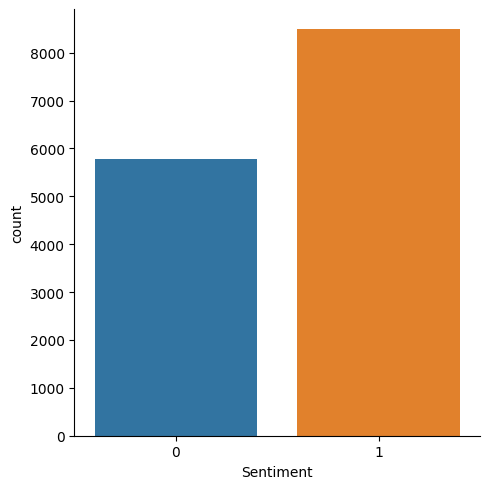

In [ ]:
# plot distribution of classes
sb.catplot(x="Sentiment", kind="count", data=df)

In [ ]:
pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


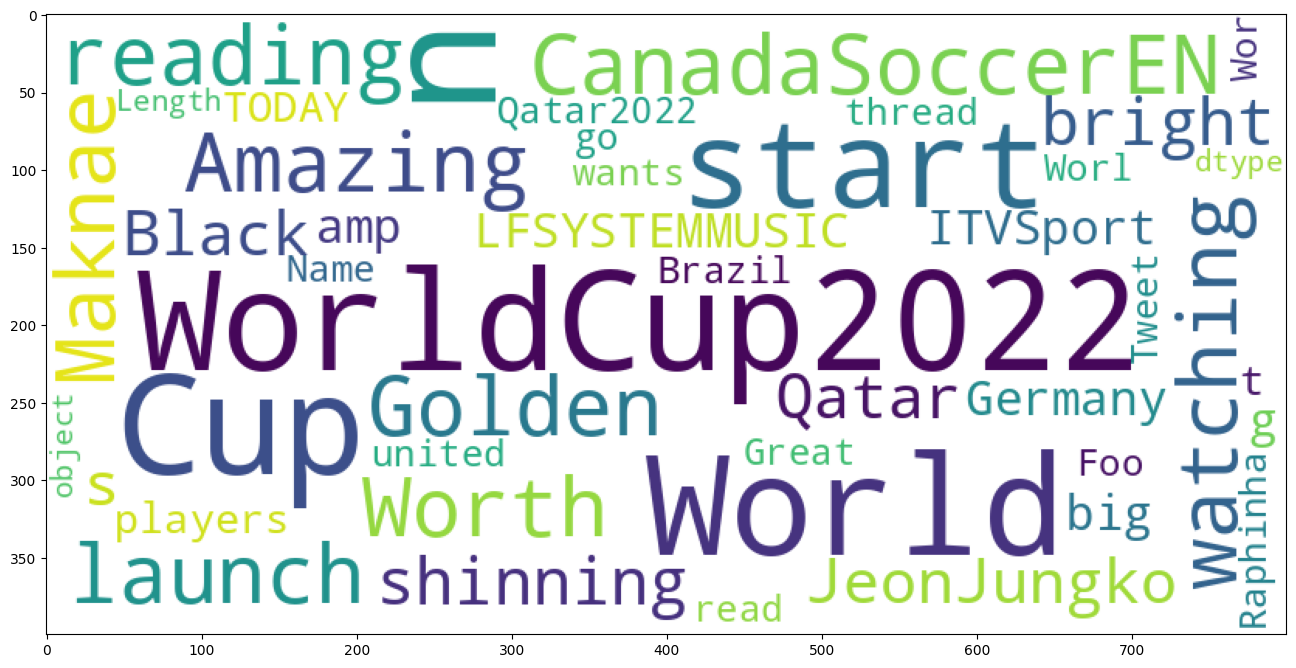

In [ ]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS,
                max_words = 100, max_font_size = 100, 
                random_state = 15, width=800, height=400)

plt.figure(figsize=(16, 12))
wordcloud.generate(str(df.loc[df['Sentiment'] == 1, 'Tweet']))
plt.imshow(wordcloud)

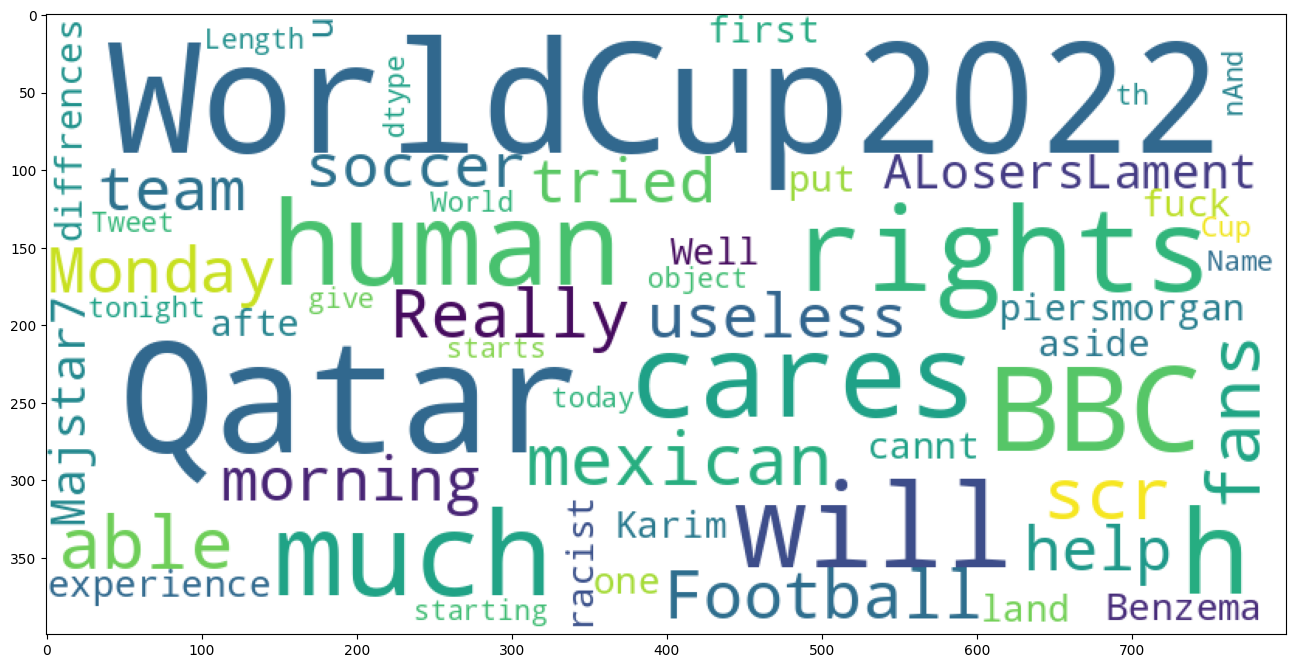

In [ ]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(df.loc[df['Sentiment'] == 0, 'Tweet']))
plt.imshow(wordcloud)

## Data Training
Here we map the data to train in order to implement our algorithms

In [ ]:
# tf-idf processing and train-test split

X = df.Tweet
y = df.Sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
X_train.shape

(10704,)

In [ ]:
# tfidf vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

X_train = vectorizer.fit_transform(X_train)  # fit and transform the train data
X_test = vectorizer.transform(X_test)        # transform only the test data

# Naive Bayes

In [ ]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
pred = nb.predict(X_test)

In [ ]:
confusion_matrix(y_test, pred)

array([[1188,  300],
       [ 135, 1946]])

In [ ]:
accuracy_score(y_test, pred)

0.8781171196413561

# Logistical Regression

In [ ]:
clf = LogisticRegression(C=2.5, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished


LogisticRegression(C=2.5, n_jobs=4, random_state=17, verbose=1)

In [ ]:
pred2 = clf.predict(X_test)

In [ ]:
confusion_matrix(y_test, pred2)

array([[1260,  228],
       [ 174, 1907]])

In [ ]:
accuracy_score(y_test, pred2)

0.8873634071168395

# Neural Network

In [ ]:
import nltk

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df.head()

Tweet  Sentiment
1  Amazing @CanadaSoccerEN  #WorldCup2022 launch ...          1
2        Worth reading while watching #WorldCup2022           1
3  Golden Maknae shinning bright\n\n\n#JeonJungko...          1
4  If the BBC cares so much about human rights, h...          0
5  And like, will the mexican fans be able to scr...          0

In [ ]:
# text preprocessing
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

stopwords = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words=list(stopwords), binary=True)

In [ ]:
# set up X and y
X = vectorizer.fit_transform(df.Tweet)
y = df.Sentiment

In [ ]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(solver='lbfgs', alpha=0.01)
classifier.fit(X_train, y_train)

MLPClassifier(alpha=0.01, solver='lbfgs')

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
pred = classifier.predict(X_test)
print('accuracy score: ', accuracy_score(y_test, pred))
print('precision score: ', precision_score(y_test, pred))
print('recall score: ', recall_score(y_test, pred))
print('f1 score: ', f1_score(y_test, pred))

accuracy score:  0.8924068366489213
precision score:  0.9046256556986171
recall score:  0.9115809706871696
f1 score:  0.9080899952130206
